In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage
import json
from PIL import Image, ImageDraw

In [2]:
# Root directory of the project
ROOT_DIR = r"C:\Users\ruben.popper\Desktop\TF2\1st"
sys.path.append(ROOT_DIR)  
sys.path.insert(0, os.path.abspath('mrcnn'))

In [3]:
# Import mrcnn libraries
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from pycocotools import mask as maskUtils

In [4]:
%matplotlib inline 
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

#visualizations setup
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [5]:
############################################################
#  Configurations
############################################################


class ModanetConfig(Config):
    """Configuration for training on the custom dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "modanet"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 13  # Background + number of classes (Here, 2)

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 250

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
class ModanetDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        source_name = "modanet_coco_like_anns"

        self.add_class(source_name, 1, "bag")
        self.add_class(source_name, 2, "belt")
        self.add_class(source_name, 3, "boots")
        self.add_class(source_name, 4, "footwear")
        self.add_class(source_name, 5, "outer")
        self.add_class(source_name, 6, "dress")
        self.add_class(source_name, 7, "sunglasses")
        self.add_class(source_name, 8, "pants")
        self.add_class(source_name, 9, "top")
        self.add_class(source_name, 10, "shorts")
        self.add_class(source_name, 11, "skirt")
        self.add_class(source_name, 12, "headwear")
        self.add_class(source_name, 13, "scarf/tie")
        
        
        # Add the class names using the base method from utils.Dataset

        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)

        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                #integrity check:
                #only consider annotations for which there is an image
                if image_file_name in os.listdir(images_dir):
                    image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                    try:
                        image_annotations = annotations[image_id]
                        # Add the image using the base method from utils.Dataset
                        self.add_image(
                            source=source_name,
                            image_id=image_id,
                            path=image_path,
                            width=image_width,
                            height=image_height,
                            annotations=image_annotations
                        )
                    except:
                        pass
        
        
        
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)
            
        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [6]:
train_path = 'datasets/train/'
val_path = 'datasets/val/'

# Training dataset
dataset_train = ModanetDataset()
dataset_train.load_data(train_path + 'instances_train.json', train_path + 'images')
dataset_train.prepare()

# Validation dataset
dataset_val = ModanetDataset()
dataset_val.load_data(val_path + 'instances_val.json',  val_path + 'images')
dataset_val.prepare()

In [7]:
config = ModanetConfig()

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

(None, 26)


In [8]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\ruben.popper\Desktop\TF2\1st\logs\modanet20221026T0957\mask_rcnn_modanet_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrc

C:\Users\ruben.popper\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\ruben.popper\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/

250/250 [==============================] - ETA: 0s - batch: 124.5000 - size: 1.0000 - loss: 9.8898 

C:\Users\ruben.popper\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


250/250 [==============================] - 10366s 41s/step - batch: 124.5000 - size: 1.0000 - loss: 9.8898 - val_loss: 3.8827
Training took 173.2 minutes


In [48]:
class InferenceConfig(ModanetConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.01

In [49]:
inference_config = InferenceConfig()

In [50]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

(None, 26)


In [52]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()
model_path = r"C:\Users\ruben.popper\Desktop\TF2\1st\mask_rcnn_coco.h5"
# Load trained weights (fill in path to trained weights here)
# assert model_path != "", "Provide path to trained weights"
# print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True, exclude=[ "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

In [53]:
import skimage
real_test_dir = 'datasets/test/images'
image_paths = []
for filename in os.listdir(real_test_dir)[:5]:
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))
print(image_paths)

['datasets/test/images\\0000211.jpg', 'datasets/test/images\\0000649.jpg', 'datasets/test/images\\0000767.jpg', 'datasets/test/images\\0000779.jpg', 'datasets/test/images\\0001010.jpg']


Processing 1 images
image                    shape: (600, 400, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max:  600.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


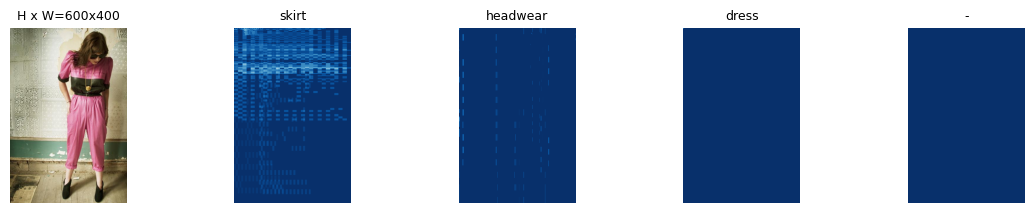

Processing 1 images
image                    shape: (600, 400, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max:  600.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


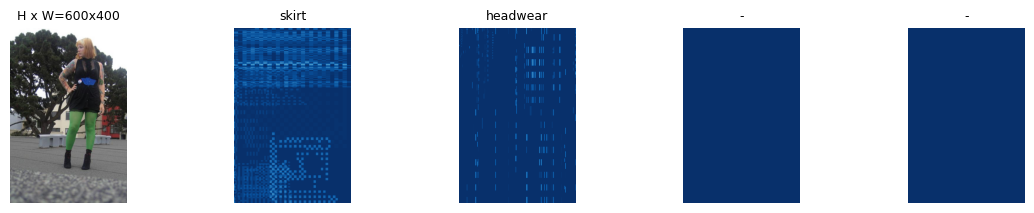

Processing 1 images
image                    shape: (600, 400, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max:  600.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


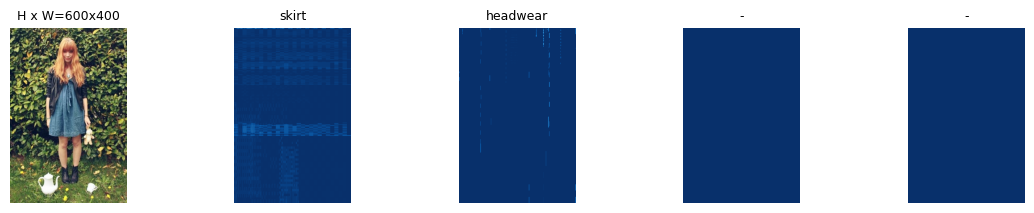

Processing 1 images
image                    shape: (600, 400, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max:  600.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


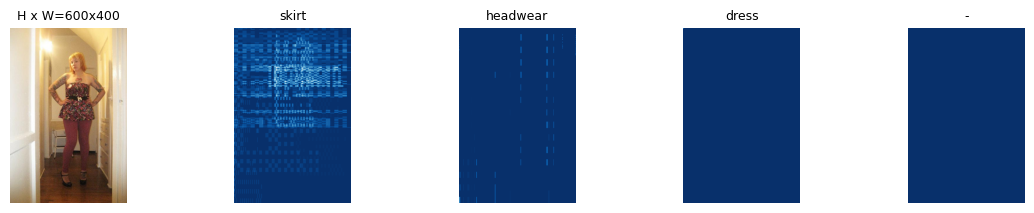

Processing 1 images
image                    shape: (600, 400, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max:  600.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


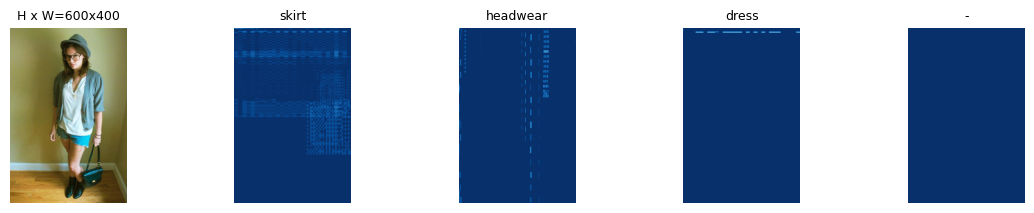

In [54]:
for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_top_masks(img,  r['masks'], r['class_ids'], dataset_val.class_names)
    
    

In [26]:
for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    print(results)

Processing 1 images
image                    shape: (600, 400, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max:  600.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
[{'rois': array([[173,   0, 328, 251],
       [243,   0, 589, 236],
       [383,  83, 600, 400],
       [195,   0, 196,   1],
       [ 21,   0,  22,   1],
       [287,   0, 288, 400],
       [291,   0, 292, 400],
       [300,   0, 301, 400],
       [295,   0, 296, 400],
       [295,   0, 296, 400],
       [293,   0, 294, 400],
       [293,   0, 294, 400],
       [285,   0, 286, 400],
       [284,   0, 285, 400],
       [251,   0, 252, 400],
       [275,   0, 276, 400],
       [247,   0, 248, 400],
       [283,   0, 284, 400],
       [252,   0, 253, 400],
       [268,   0, 269, 400],
       [

[{'rois': array([[220,   0, 600, 400],
       [167,  13, 312, 227],
       [152,   0, 565,  50],
       [  7,   0,   8,   1],
       [  5,   0,   6,   1],
       [  5,   0,   6,   1],
       [  4,   0,   5,   1],
       [  5,   0,   6,   1],
       [  4,   0,   5,   1],
       [  5,   0,   6,   1],
       [  5,   0,   6,   1],
       [  4,   0,   5,   1],
       [  4,   0,   5,   1],
       [  4,   0,   5,   1],
       [  4,   0,   5,   1],
       [  4,   0,   5,   1],
       [  4,   0,   5,   1],
       [  4,   0,   5,   1],
       [  4,   0,   5,   1],
       [  4,   0,   5,   1],
       [  4,   0,   5,   1],
       [  4,   0,   5,   1],
       [  5,   0,   6,   1],
       [  5,   0,   6,   1],
       [  5,   0,   6,   1],
       [  5,   0,   6,   1],
       [  4,   0,   5,   1],
       [  4,   0,   5,   1],
       [  4,   0,   5,   1],
       [  5,   0,   6,   1],
       [  4,   0,   5,   1],
       [  5,   0,   6,   1],
       [  4,   0,   5,   1],
       [  5,   0,   6,   1],
    

[{'rois': array([[112,   0, 117,   1],
       [267,   0, 467, 400],
       [156,   0, 316, 400],
       [  0,   0,  55,   1],
       [212,   0, 213,  38],
       [214,   0, 216,   1],
       [212,   0, 215,   1],
       [121,   0, 123, 349],
       [ 83, 275,  86, 400],
       [ 52,   0,  63,  66],
       [192,   0, 193,  99],
       [105,   0, 108,   1],
       [138,   0, 139, 400],
       [202,   0, 203,   1],
       [154,   0, 155, 400],
       [108,   0, 110, 400],
       [ 98,   0, 107,  17],
       [171,   0, 175,   1],
       [151,   0, 152, 400],
       [173,   0, 176,   1],
       [ 96,   0,  98, 148],
       [138,   0, 140,   1],
       [ 87,   0,  93,   1],
       [169,   0, 171,   8],
       [ 98,   0,  99, 400],
       [ 15,   0,  17, 400],
       [117,   0, 119, 124],
       [191,   0, 192, 119],
       [124,   0, 126, 400],
       [191,   0, 192, 109],
       [158,   0, 162,   1],
       [191,   0, 193, 114],
       [123,   0, 125, 108],
       [ 80,   0,  82, 175],
    